In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
%matplotlib inline

encoding = "ISO-8859-1"

In [13]:
from keras.models import Model, load_model
from keras.layers import LSTM, Dense, Concatenate, Input, Dropout, Add, BatchNormalization
from keras.regularizers import l2
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [3]:
train = pd.read_csv('train.csv', encoding=encoding, index_col=['id'])
train.head()

,product_uid,product_title,search_term,relevance
id,,,,
2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [4]:
products = pd.read_csv('product_descriptions.csv', encoding=encoding, index_col=['product_uid'])
train['description'] = train.product_uid.map(products.product_description)
train['product'] = train['product_title'] + '. ' + train['description'] 
train = train.drop(columns=['product_title', 'description'])
train.head()

,product_uid,search_term,relevance,product
id,,,,
2,100001,angle bracket,3.00,Simpson Strong-Tie 12-Gauge Angle. Not only do...
3,100001,l bracket,2.50,Simpson Strong-Tie 12-Gauge Angle. Not only do...
9,100002,deck over,3.00,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...
16,100005,rain shower head,2.33,Delta Vero 1-Handle Shower Only Faucet Trim Ki...
17,100005,shower only faucet,2.67,Delta Vero 1-Handle Shower Only Faucet Trim Ki...


In [5]:
%%time
embeddings = {}
emb_dim = 300
with open(f'emb/glove.42B.{emb_dim}d.txt') as f:
    for line in f:
        values = line.strip().split()
        embeddings[values[0]] = np.array(values[1:], np.float32)


CPU times: user 1min 20s, sys: 1.87 s, total: 1min 22s
Wall time: 1min 22s


Проверим распределение описаний товара по длине токене

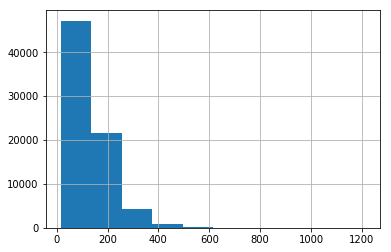

In [6]:
train['product'].apply(lambda x: len([1 for item in word_tokenize(x) if item in embeddings])).hist()

Выберем 400 в качестве длинны последовательности для входа LSTM для Названия + описания товара

In [7]:
train['search_term'].apply(lambda x: len(word_tokenize(x))).max()

17

Функция для подготовки данных для модели и генератор батчей. Памяти всего 16ГБ

In [6]:
fields_size = {'product':400, 'search_term':30}

def text_to_vectors(line, size):
    tokens = word_tokenize(line.lower())
    tokens = [embeddings.get(token) for token in tokens][:size-1]
    tokens = np.array([token for token in tokens if token is not None] + [np.zeros(emb_dim, np.float32)])
    result = np.zeros((size, emb_dim), np.float32)
    result[:tokens.shape[0], :tokens.shape[1]] = tokens
    return result

In [7]:
n = train.shape[0]
print(n)
def generator(batch_size, start_=0., end_=1.):
    X = []
    y = []
    while True:
        start = int(n * start_)
        end = int(n * end_)
        rows = np.random.randint(start, end, batch_size)
        for field, size in fields_size.items():
            inp = np.array([text_to_vectors(train[field].iloc[row], size) for row in rows])
            X.append(inp)
        y = (train['relevance'].iloc[rows].values - 2.)
        yield X, y
        X, y = [], []

74067


In [ ]:
reg_l2 = 0.0001
input1 = Input(shape=(None, emb_dim), name='input1')
lstm1 = LSTM(emb_dim, kernel_regularizer=l2(reg_l2))(input1)

input2 = Input(shape=(None, emb_dim), name='input2')
lstm2 = LSTM(emb_dim, kernel_regularizer=l2(reg_l2))(input2)

regressor = Concatenate()([lstm1, lstm2])
regressor = Dropout(0.5)(regressor)
regressor = Dense(64)(regressor)
regressor = Dropout(0.5)(regressor)
regressor = Dense(64)(regressor)
out = Dense(1, activation='tanh', name='output')(regressor)

model = Model(inputs=[input1, input2], outputs=out)

model.compile(loss=root_mean_squared_error, optimizer='adam')

tgen = generator(400, end_=0.8)
vgen = generator(400, start_=0.8)
model.fit_generator(tgen,
                    steps_per_epoch=150, epochs=10,
                    validation_steps=30,
                    validation_data=vgen
                   )

In [13]:
model.save('models/lstm2-10.model')

In [8]:
test = pd.read_csv('test.csv', encoding=encoding)
test['description'] = test.product_uid.map(products.product_description)
test['product'] = test['product_title'] + '. ' + test['description'] 
test_n = test.shape[0]
test.head()

,id,product_uid,product_title,search_term,description,product
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie 12-Gauge Angle. Not only do...
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie 12-Gauge Angle. Not only do...
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie 12-Gauge Angle. Not only do...
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie 12-Gauge Angle. Not only do...
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie 12-Gauge Angle. Not only do...


In [9]:
sample_n = 5000

def get_prediction(model, df):
    test_n = df.shape[0]
    X, Y = [], []
    for i in range(test_n // sample_n + 1):
        if (i % 5 == 0):
            print(i)
        i_start, i_end = i * sample_n, min((i + 1) * sample_n, test_n)
        for field, size in fields_size.items():
            inp = np.array([text_to_vectors(df[field].iloc[i_row], size) for i_row in range(i_start, i_end)])
            X.append(inp)
        Y.append(model.predict(X))
        X = []
    y_pred = np.concatenate(Y)
    y_pred[y_pred > 3.] = 3.
    y_pred[y_pred < 1.] = 1.
    return y_pred


In [16]:
y_pred = get_prediction(model, test)
results = pd.DataFrame({'id':test.id.values, 'relevance':y_pred.flatten()})
results.to_csv('lstm2-10.csv', header=True, index=False)

0
5
10
15
20
25
30


Результат 0.54600

In [15]:
reg_l2 = 0.0001
input1 = Input(shape=(None, emb_dim), name='input1')
lstm1 = LSTM(emb_dim, return_sequences=True,
             kernel_regularizer=l2(reg_l2))(input1)
lstm1 = LSTM(emb_dim, go_backwards=True,
             kernel_regularizer=l2(reg_l2))(lstm1)

input2 = Input(shape=(None, emb_dim), name='input2')
lstm2 = LSTM(emb_dim, return_sequences=True,
             kernel_regularizer=l2(reg_l2))(input2)
lstm2 = LSTM(emb_dim, go_backwards=True,
             kernel_regularizer=l2(reg_l2))(lstm2)


regressor = Concatenate()([lstm1, lstm2])
regressor = Dropout(0.3)(regressor)
regressor = Dense(128)(regressor)
regressor = Dropout(0.3)(regressor)
regressor = Dense(128)(regressor)
out = Dense(1, name='output')(regressor)

model = Model(inputs=[input1, input2], outputs=out)

model.compile(loss=root_mean_squared_error, optimizer='adam')

tgen = generator(400, end_=0.8)
vgen = generator(400, start_=0.8)
model.fit_generator(tgen,
                    steps_per_epoch=150, epochs=5,
                    validation_steps=30,
                    validation_data=vgen
                   )

Epoch 1/5
150/150 [==============================] - 319s 2s/step - loss: 0.6037 - val_loss: 0.5713
Epoch 2/5
150/150 [==============================] - 313s 2s/step - loss: 0.5455 - val_loss: 0.5468
Epoch 3/5
150/150 [==============================] - 313s 2s/step - loss: 0.5301 - val_loss: 0.5668
Epoch 4/5
150/150 [==============================] - 313s 2s/step - loss: 0.5173 - val_loss: 0.5466
Epoch 5/5
150/150 [==============================] - 313s 2s/step - loss: 0.5082 - val_loss: 0.5341


In [16]:
model.fit_generator(tgen,
                    steps_per_epoch=150, epochs=3,
                    validation_steps=30,
                    validation_data=vgen
                   )

Epoch 1/3
150/150 [==============================] - 314s 2s/step - loss: 0.4998 - val_loss: 0.5334
Epoch 2/3
150/150 [==============================] - 313s 2s/step - loss: 0.4927 - val_loss: 0.5334
Epoch 3/3
150/150 [==============================] - 313s 2s/step - loss: 0.4806 - val_loss: 0.5393


In [13]:
model.save('models/bi-lstm')

In [18]:
y_pred = get_prediction(model, train)
train['pred'] = y_pred
train['diff'] = (train['relevance'] - train['pred']).abs()
train.sort_values(by='diff', ascending=False)

0
5
10


,product_uid,search_term,relevance,product,pred,diff
id,,,,,,
214310,200546,spill proof pail,1.0,3/16 in. Proof Coil Chain Zinc Plated 250 ft. ...,3.000000,2.000000
42851,110380,bathroom soap dish,1.0,Lenape 24 in. Towel Bar in White. Crafted of k...,2.836181,1.836181
49621,112596,liberty drawer slides,1.0,Liberty 2-1/3 in. x 2-3/4 in. Nickel 35 mm 105...,2.835572,1.835572
216351,202235,dog door high tech,1.0,High Tech Pet 0.63 in. x 0.63 in. Required Bat...,2.804787,1.804787
200148,189102,swffer mop,1.0,Genuine Joe Dust Mop Frame. Mop frame is desig...,2.797928,1.797928
180623,174933,sylvania chrome top,1.0,Barclay Products 5.6 ft. Cast Iron Ball and Cl...,2.784721,1.784721
187021,179431,sylvania chrome top,1.0,Barclay Products 5.6 ft. Cast Iron Double Roll...,2.784721,1.784721
192976,183675,sylvania chrome top,1.0,Barclay Products 4.5 ft. Cast Iron Ball and Cl...,2.784721,1.784721
27483,105728,are rug,1.0,Hoover Turbo Scrub Carpet Washer. High perform...,2.766523,1.766523


Дообучим модель с меньшим learning rate

In [17]:
print(K.get_value(model.optimizer.lr))
K.set_value(model.optimizer.lr, 0.0005)
print(K.get_value(model.optimizer.lr))

0.001
0.0005


In [18]:
model.fit_generator(tgen,
                    steps_per_epoch=150, epochs=3,
                    validation_steps=30,
                    validation_data=vgen
                   )

Epoch 1/3
150/150 [==============================] - 313s 2s/step - loss: 0.4684 - val_loss: 0.5369
Epoch 2/3
150/150 [==============================] - 313s 2s/step - loss: 0.4652 - val_loss: 0.5478
Epoch 3/3
150/150 [==============================] - 313s 2s/step - loss: 0.4576 - val_loss: 0.5428


Создадим сабмишн, для промежуточной проверки результата

In [19]:
y_pred = get_prediction(model, test)
results = pd.DataFrame({'id':test.id.values, 'relevance':y_pred.flatten()})
results.to_csv('lstm2-10.csv', header=True, index=False)

0
5
10
15
20
25
30


Результат 0.54159 на test

Результат хуже чем бейзлайн. Бейзлайн был сделан "в лоб", без рассмотрения каких-либо фич. Проблема в данном подходе в том, что эмбединги хорошо работают для фраз и предложений в рамках естественного языка, а search_term как правило не естественнен. При рассмотре других решений на kaggle, нейронки не встречались.